# Evolution of cell size control is canalized towards adders or sizers by cell cycle structure and selective pressures
#### Félix Proulx-Giraldeau<sup>1</sup>, Jan Skotheim<sup>2,3</sup>, Paul François<sup>1</sup>

1 - Department of Physics, McGill University, Canada  
2 - Department of Biology, Stanford University, USA  
3 - Chan Zuckerberg Biohub, San Francisco, USA  

(C) Félix Proulx-Giraldeau, April 2022, McGill University
Contact: felix.proulx-giraldeau@mail.mcgill.ca 
___ 

## Analysis pipeline notebook

In this notebook, we will go through the standard analysis pipeline we used to quantify the size control properties of Models __A1__, __A2__ and __B__ from the main text. We refer the reader to the Supplement for additional information on the implementation of the pipeline. 

First, we import various modules, functions and parameter values relevant to this project. 

In [104]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression


def G1S_prob(y):
    """Probability of triggering the G1/S transition at the next time step.
    
    Args:
        - y (float): Decision-maker for the G1/S transition. Default is the I quantity y[2]*y[0]. 
            
    Return:
        - G1/S_prob (float). Probability for the G1/S transition occuring at the next time step. 
    """
    r = np.exp(np.power((y/t_g1s),n_g1s),dtype=np.float128)
    return 2/(1+r)

def HillA(A,t,n):
    """Compute the Hill activation rate.
    
    Args:
        - A (float or array-like (1 x N_time_step)): Activator concentration level.
        - t (float): Hill threshold.
        - n (float): Hill coefficient. 
            
    Return:
        - HillA(A,t,n) (float or array-like (1 x N_time_step) depending on dimensions of A): Hill activation
        rate(s).
    """
    r = np.power(np.divide(A,t),n)
    return np.divide(r,np.ones_like(r)+r)

def HillR(R,t,n):
    """Compute the Hill repression rate.
    
    Args:
        - R (float or array-like (1 x N_time_step)): Repressor concentration level.
        - t (float): Hill threshold.
        - n (float): Hill coefficient. 
            
    Return:
        - HillR(R,t,n) (float or array-like (1 x N_time_step) depending on dimensions of R): Hill repression
        rate(s).
    """
    r = np.power(np.divide(R,t),n)
    return np.divide(np.ones_like(R),np.ones_like(R) + r)

def compute_noisy_inc(rate,vol):
    """Computes the Euler-Maruyama noisy increment for the integrator. 
    
    Args:
        - rate (float): Deterministic rate.
        - vol (float): Simulate molecular noise level in a cell volume = 'vol'. 
            
    Return:
        - noisy rate (float): Deterministic rate to which we add a gaussian white noise of mean 0 and 
        variance corresponding to the deterministic rate.
    """
    conc_scale = 1 # Concentration rescaling factor. 
    step = dt      # Time step from the hyperparameters dictionnary. 
    return rate + np.random.normal()*np.sqrt((rate)/(conc_scale*vol*step))

def compute_increment_fluct(y,break_sensing=0):
    """Compute the stochastic ODE increment for Model B from the main text.
    
    Args:
        - y (array-like,N_variables x 1): State variables of the system at the current time step.
        - break_sensing (bool): If = 0, then we use the actual cell volume y[0] to simulate the molecular 
        noise. If = 1, then we use the control volume y[6]. y[6] tracks a cell born at 'control_volume' 
        that always comes back to 'control_volume' whenever a division happens. 
        
    Return:
        - ds (array-like, N_variables x 1): State variables' increments for the dynamics at the current 
        time step. For the integrator. 
    """ 
    switch = y[1]  # S/G2/M Switch
    if break_sensing:
        vol = y[6] # Control volume at birth + exponential growth of the cell with absolute growth rate g_rate.
    else:
        vol = y[0]
    
    ds = np.zeros_like(y) # Increments
    g =  globals()['compute_noisy_inc'] # Compute the noisy increment associated with a rate. 
    
    ### Transcription ###
    rate = max(p_2*max(HillA(switch,t_12,n_12),HillA(y[3],t_32,n_32)),0)
    inc = g(rate,vol)
    ds[2] += inc
    rate = max(p_3*HillA(y[3],t_33,n_33),0)
    inc = g(rate,vol)
    ds[3] += inc
    rate = max(b_4,0)
    inc = g(rate,vol)
    ds[4] += inc
    
    ### Degradation ###
    rate = d_2*y[2]
    inc = g(rate,vol)
    ds[2] -= inc
    rate = d_3*y[3]
    inc = g(rate,vol)
    ds[3] -= inc
    rate = d_4*y[4]
    inc = g(rate,vol)
    ds[4] -= inc
    rate = d_5*y[5]
    inc = g(rate,vol)
    ds[5] -= inc
    
    ### Dilution -- NO NOISE ###
    rate = g_rate*y[2]
    ds[2] -= rate
    rate = g_rate*y[3]
    ds[3] -= rate
    rate = g_rate*y[4]
    ds[4] -= rate
    rate = g_rate*y[5]
    ds[5] -= rate
    
    ### PPI -- CORRELATIONS ###
    rate = kf*y[3]*y[4]
    inc = g(rate,vol)
    ds[3] -= inc
    ds[4] -= inc
    ds[5] += inc
    rate = kb*y[5]
    inc = g(rate,vol)
    ds[3] += inc
    ds[4] += inc
    ds[5] -= inc
    return ds
    
def compute_increment(y,break_sensing=0):
    """Compute the deterministic ODE increment for Models A1 and A2 from the main text.
    
    Args:
        - y (array-like,N_variables x 1): State variables of the system at the current time step.
        - break_sensing (bool): Useless in this function, but included for symmetry with 
        'computer_increment_fluct' function. For Models A1 and A2, the control volume influences the G1/S
        transition and is handled in the integrator itself.
            
    Return:
        - ds (array-like, N_variables x 1): State variable increments for the dynamics at the current 
        time step. For the integrator. 
    """ 
    switch = y[1] # S/G2/M Switch 
    ds = np.zeros_like(y) # Increments
    
    ### Transcription ###
    rate = max(p_2*HillA(switch,t_12,n_12),b_2)
    if model == 'A2': # Model A2
        rate *= HillR(y[3],t_32,n_32)
    inc = rate # No noise for Models A1 and A2. 
    ds[2] += inc
    
    rate = p_3*HillR(y[2],t_23,n_23)
    if model == 'A2': # Model A2
        rate *= HillR(switch,t_13,n_13)
    inc = rate # No noise for Models A1 and A2. 
    ds[3] += inc
    
    ### Degradation ###
    rate = d_2*y[2]
    inc = rate # No noise for Models A1 and A2. 
    ds[2] -= inc
    rate = d_3*y[3]
    inc = rate # No noise for Models A1 and A2. 
    ds[3] -= inc
    rate = d_4*y[4]
    inc = rate # No noise for Models A1 and A2. 
    ds[4] -= inc
    rate = d_5*y[5]
    inc = rate # No noise for Models A1 and A2. 
    ds[5] -= inc
    
    ### Dilution -- NO NOISE ###
    rate = g_rate*y[2]
    ds[2] -= rate
    rate = g_rate*y[3]
    ds[3] -= rate
    rate = g_rate*y[4]
    ds[4] -= rate
    rate = g_rate*y[5]
    ds[5] -= rate
    
    ### PPI -- CORRELATIONS ###
    rate = kf1*y[2]*y[3]
    inc = rate # No noise for models A1 and A2. 
    ds[2] -= inc
    ds[3] -= inc
    ds[4] += inc
    
    rate = kb1*y[4]
    inc = rate # No noise for models A1 and A2. 
    ds[2] += inc
    ds[3] += inc
    ds[4] -= inc
    
    rate = kf2*y[2]*y[2]
    inc = rate # No noise for models A1 and A2. 
    ds[2] -= inc
    ds[5] += inc
    
    rate = kb2*y[5]
    inc = rate # No noise for models A1 and A2. 
    ds[2] += inc
    ds[5] -= inc
    return ds

def volume_response(V_eq,n_points=21):
    """Produce the volume response curve T(V_c) described in the main text and the supplement.
    
    Args:
        - V_eq (float): Estimate of the equilibrium volume where the induced period is equal to the doubling 
        time. 
        - n_points (int). Number of simulations to run to produce the T(V_c) curve between +/- 35% of V_eq. 
        Default is 21. 
            
    Return:
        - control_volume_range, cycle_length (tuple: list, 1 x n_points & list, 1 x n_points): Lists of the 
        control volumes value tested and induced mean cycle length for the corresponding control volumes. 
    """
    control_volume_range = np.linspace(0.35*V_eq,1.65*V_eq,n_points)
    cycle_length = []

    for i, iv in enumerate(control_volume_range):
        clear_output()
        print('%i simulations done out of %i'%(i,n_points))
        globals()['control_volume'] = iv # Set the control volume value
        t_temp, y_temp = integrate_euler(end_time = 1000,break_sensing=1)
        analyze_dict_temp = analyze_run(t_temp,y_temp)
        cycle_length.append(np.mean(analyze_dict_temp['cycle_length'][5:]))
    clear_output()
    print('Done!')    
    return control_volume_range, cycle_length

def volume_response_fluct(min_control_volume = 6, max_control_volume = 16,n_dist=6):
    """Produce the control volume at birth time distributions for Model B described in the main text and 
    the supplement.
    
    Args:
        - min_control_volume (float): Minimum value of control volume to produce a time distribution for. 
        Default is 6.
        - max_control_volume (float): Maximum value of control volume to produce a time distribution for. 
        Default is 16.
        - n_dist (int). Number of distributions to compute for control volumes equally spaced between 
        min_control_volume and max_control_volume.
            
    Return:
        - control_volume_range, cycle_length_data (tuple: list, 1 x n_points & list of lists, n_div x n_points): 
        Lists of the control volumes value tested and induced cycle length distributions for the corresponding 
        control volumes at birth. 
    """
    control_volume_range = np.linspace(min_control_volume,max_control_volume,n_dist)
    cycle_length_data = []

    for i, iv in enumerate(control_volume_range):
        clear_output()
        print('%i simulations done out of %i'%(i,n_dist))
        globals()['control_volume'] = iv # Set the control volume value
        t_temp, y_temp = integrate_euler(end_time = 2500,break_sensing=1)
        analyze_dict_temp = analyze_run(t_temp,y_temp)
        cycle_length_data.append(analyze_dict_temp['cycle_length'][5:])
    clear_output()
    print('Done!')    
    return control_volume_range, cycle_length_data


def analyze_run(t,y): 
    """Analyze a simulation and extract lineage data.
    
    Args:
        - t (array-like,1 x N_time_points): Time vector of the simulation.
        - y (array-like,N_variables x N_time_points): State variables of the simluation.
            
    Return:
        - dict_t (dictionary): Contains lists (length N_div) of state variable values at moments during the
        cell cycle, namely 'birth', 'G1/S' and 'div'. State variables can be 't' for time, 'volume' and 'S2'
        through 'S7'.
        We also compute the 'mean' and 'std' of state variables' distributions FOR EACH 'G1', S/G2/M' and 
        over the whole 'cycle'.
    """
    n_var = len(y[:,0])               # Number of variables in the system.
    sum_sumsq = np.zeros([n_var,2,2]) # Temporarily track the state variables' sum and sum of squared elements at each time step.
    
    dict_t = {}
    cycle_events = ['birth','G1/S','div']  # Track 'birth','G1/S' and 'div' events
    cycle_stats = ['mean','std']            # We will also compute the 'mean' and 'std' of state variables
    cycle_periods = ['G1','S/G2/M','cycle']     # during 'G1', 'S/G2/M' and the whole 'cycle' 

    #### Initialize the dictionary keys and birth values ###
    for k in range(n_var):
        for event in cycle_events:
            if k == 0: # Only once
                dict_t['t_'+event] = []
            dict_t['S'+str(k)+'_'+event] = [] 
            if event == 'birth':
                dict_t['S'+str(k)+'_'+event].append(y[k,0])
                if k == 0: # Only once
                    dict_t['t_'+event].append(t[0])
        for stat in cycle_stats:
            for period in cycle_periods:
                dict_t['S'+str(k)+'_'+stat+'_'+period] = []
    n_step_cycle = 0 # Track number of time steps during each period of the cell cycle
    
    #### Analyze the simulation ###
    for i in range(len(y[1,:])-1):
        for k in range(n_var):
            for p in range(2):
                sum_sumsq[k,0,p] += y[k,i]    # Track state var sum. p = 0 for G1 and S/G2/M. p = 1 for the cycle.
                sum_sumsq[k,1,p] += y[k,i]**2 # Track state var sum of squares.
        n_step_cycle += 1 # Count
        # Did a cell cycle transition occur?
        diff_cell_cycle = y[1,i+1]-y[1,i]
        # G1/S.
        if (diff_cell_cycle == +1 and not pombe) or (diff_cell_cycle == -1 and pombe): 
            for k in range(n_var):
                dict_t['S'+str(k)+'_G1/S'].append(y[k,i])
                dict_t['S'+str(k)+'_mean_G1'].append(sum_sumsq[k,0,0]/n_step_cycle)
                dict_t['S'+str(k)+'_std_G1'].append(np.sqrt(sum_sumsq[k,1,0]/n_step_cycle - (sum_sumsq[k,0,0]/n_step_cycle)**2))
                sum_sumsq[k,0,0], sum_sumsq[k,1,0] = 0,0 # Reset.
            dict_t['t_G1/S'].append(t[i])
            n_step_prev_G1 = n_step_cycle # Track number of steps in G1 for whole cycle statistics
            n_step_cycle = 0 # Reset
        # Division/Birth.
        elif (diff_cell_cycle == -1 and not pombe) or (diff_cell_cycle == 1 and pombe):
            for k in range(n_var):
                dict_t['S'+str(k)+'_div'].append(y[k,i])
                dict_t['S'+str(k)+'_birth'].append(y[k,i+1])
                dict_t['S'+str(k)+'_mean_S/G2/M'].append(sum_sumsq[k,0,0]/n_step_cycle)
                dict_t['S'+str(k)+'_mean_cycle'].append(sum_sumsq[k,0,1]/(n_step_cycle+n_step_prev_G1))
                dict_t['S'+str(k)+'_std_S/G2/M'].append(np.sqrt(sum_sumsq[k,1,0]/n_step_cycle - (sum_sumsq[k,0,0]/n_step_cycle)**2))
                dict_t['S'+str(k)+'_std_cycle'].append(np.sqrt(sum_sumsq[k,1,1]/(n_step_cycle+n_step_prev_G1) - (sum_sumsq[k,0,1]/(n_step_cycle+n_step_prev_G1))**2))
                for p in range(2):
                    sum_sumsq[k,0,p], sum_sumsq[k,1,p] = 0,0 # Reset.
            dict_t['t_div'].append(t[i])
            dict_t['t_birth'].append(t[i+1])
            n_step_cycle = 0 # Reset
            
    # Check the lists' dimensions to ensure they all match   
    if len(dict_t['S0_birth']) > len(dict_t['S0_G1/S']): # Recorded one too many birth event. 
        for k in range(n_var):
            del dict_t['S'+str(k)+'_birth'][-1]
        del dict_t['t_birth'][-1]
    elif len(dict_t['S0_G1/S']) > len(dict_t['S0_div']): # Didn't reach division before the end of the simulation.
        for k in range(n_var):
            del dict_t['S'+str(k)+'_birth'][-1], dict_t['S'+str(k)+'_G1/S'][-1], dict_t['S'+str(k)+'_mean_G1'][-1], dict_t['S'+str(k)+'_std_G1'][-1]
        del dict_t['t_birth'][-1], dict_t['t_G1/S'][-1]
    
    # Compute the lengths of each cycle periods for each generation in the lineage. 
    dict_t['G1_length'] = np.subtract(dict_t['t_G1/S'],dict_t['t_birth'])
    dict_t['S/G2/M_length'] = np.subtract(dict_t['t_div'],dict_t['t_G1/S'])
    dict_t['cycle_length'] = np.subtract(dict_t['t_div'],dict_t['t_birth'])
    
    # Rename 'S0' to 'volume' for clarity.
    for event in cycle_events:
        dict_t['volume_'+event] = dict_t.pop('S0_'+event)
    return dict_t

def analyze_dist(analyze_dict):
    """Extract mean, standard deviation and coefficient of variation of the distributions produced by 
    'analyze_run(t,y)'.
    
    Args:
        - analyze_dict (dictionary): Dictionary of state variable values at various moments
        of the cell cycle in the lineage. From 'analyze_run(t,y)' function.
            
    Return:
        - dist_dict (dictionary): Contains values of 'mean', 'std' and 'cv' for the distributions of 
        'analyze_dict'.
    """
    list_dist = list(analyze_dict.keys()) # List of names. 
    dist_dict = {}
    for i, dist in enumerate(analyze_dict.values()):
        mean_dist = np.mean(dist)
        std_dist = np.std(dist)
        if mean_dist != 0:
            cv_dist = std_dist/mean_dist
        else:
            cv_dist = 0
        dist_dict['mean_'+list_dist[i]] = mean_dist
        dist_dict['std_'+list_dist[i]] = std_dist
        dist_dict['cv_'+list_dist[i]] = cv_dist
    return dist_dict

def integrate_euler(end_time = 1000,break_sensing = 0):
    """Euler integrator for the simulation.
    
    Args:
        - end_time (float): End time for the simulation in artificial time units (ATU). Doubling time is ~2.77 ATU.
        - break_sensing (bool): Flag to introduce the control volume at G1/S transition for models 'A1' 
        and 'A2', or to set the molecular noise at birth for model 'B'. Default is 0 for a 'normal' simulation.
            
    Return:
        - t, y (tuple): 't' is the time vector for the simulation (1 x N_time_step). 'y' is the state 
        variables matrix for the simulation (N_var x N_time_step).
    """
    ti = 0          # Initial time. 
    tf = end_time   # Final time. 
    deltat = dt     # Time step for the integrator. 
    n = int((tf - ti)/deltat)   # N_time_step.
    t = np.arange(ti,tf,deltat) # Time vector.
    n_div = 0                   # Count the number of divisions. 
    n_var = 7                   # Number of variables in the state variable matrix. 
    y = np.zeros([n_var,n])     # State variables matrix.  
    
    ### Initial conditions ### 
    if pombe:
        timer_length = int(sg2m_timer_length/deltat)
        for j in range(0,timer_length):
            y[1,j] = 1
    if model == 'A1' or model == 'A2':
        f = globals()['compute_increment']
        sensing = 'q'
        y[0,0] = 2
        y[2,0] = 2-pombe
    elif model == 'B':
        f = globals()['compute_increment_fluct']
        sensing = 'c'
        y[0,0] = 2 + 2*np.random.rand()
        y[2,0] = 9.5 + 2*(1-2*np.random.rand())
        y[3,0] = 0.6 + 0.25*np.random.rand()
        y[4,0] = 0.6 + 0.25*np.random.rand()
        y[5,0] = 0.6 + 0.25*np.random.rand()
        if break_sensing:
            y[6,0] = control_volume
    
    ### Main loop ### 
    for i in range(1,n):
        # Update the volume. This is overwritten if the cell divides
        y[0,i] = deltat*(g_rate*y[0,i-1]) + y[0,i-1]
        if break_sensing and model == 'B':
            y[6,i] = deltat*(g_rate*y[6,i-1]) + y[6,i-1] # Simulate growth of a cell born at control_volume
        if sensing == 'q':
            if break_sensing == 1:
                g1s_var = y[2,i-1]*control_volume
            else: 
                g1s_var = y[2,i-1]*y[0,i-1]
        else:
            g1s_var = y[2,i-1]
        # Compute the tresholds for the G1/S transition
        draw_g1s = np.random.rand()
        ### G1/S transition ###
        if (G1S_prob(g1s_var) > draw_g1s) and y[1,i-1] == 0:
            real_timer_length = sg2m_timer_length*(0.25/g_rate)+0.05*3*(1-2*np.random.rand())
            timer_length = int(real_timer_length/deltat)
            for j in range(0,np.minimum(int(timer_length),n-i)):
                y[1,j+i] = 1
            if pombe: 
                y[0,i] =  y[0,i-1]/2 # Symmetric division
                if break_sensing and model == 'B':
                    y[6,i] = control_volume # Go back to control_volume at birth.
                n_div += 1
            # Euler integration of the other variables 
            ds = f(y[:,i-1],break_sensing)
            for k in range(2,n_var):
                if break_sensing and k == 6 and model == 'B':
                    continue
                y[k,i] = deltat*ds[k] + y[k,i-1]
                if y[k,i] < 0: #might happen for Langevin noise
                    y[k,i] = 1e-6
        ### Division ###
        elif y[1,i] - y[1,i-1] == -1 and not pombe:
            # Euler integration
            y[0,i] =  y[0,i-1]/2 # Symmetric division
            if break_sensing:
                y[6,i] = control_volume # Go back to control_volume at birth. 
            n_div += 1
            ds = f(y[:,i-1],break_sensing)
            for k in range(2,n_var):
                if break_sensing and k == 6 and model == 'B':
                    continue
                y[k,i] = deltat*ds[k] + y[k,i-1]
                if y[k,i] < 0:
                    y[k,i] = 1e-6
        ### Normal growth ###
        else: 
            ds = f(y[:,i-1],break_sensing)
            for k in range(2,n_var):
                if break_sensing and k == 6 and model == 'B':
                    continue
                y[k,i] = deltat*ds[k] + y[k,i-1]
                if y[k,i] < 0: # Might happen for Langevin
                    y[k,i] = 1e-6
    return t, y

def set_axes(ax):
    ax.spines["bottom"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["bottom"].set_zorder(10)
    ax.spines["top"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["top"].set_zorder(10)
    ax.spines["left"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["left"].set_zorder(10)
    ax.spines["right"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["right"].set_zorder(10)
    ax.tick_params(axis='both',
                   which = 'major',
                   labelsize=ax_fontdict['size'],
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l'],
                   width = ax_fontdict['tick_w'],)
    ax.tick_params(axis='both',
                   which = 'minor',
                   labelsize=0,
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l']/2,
                   width = ax_fontdict['tick_w']/2,)
    return ax

ax_fontdict = {'family':'sans',
               'color':'black',
               'weight':'normal',
               'size':28,
               'pad':8,
               'spines_w':2.5,
               'tick_l':9,
               'tick_w':2.5,
              }
c_g1 = '#D01C1FFF'
c_sg2m = 'midnightblue'
c_cycle = 'darkorchid'
c_birth = c_g1
c_g1s = 'orange'
c_mitosis = c_cycle
c_volume = 'maroon'
c_switch = 'grey'
c_output = 'orange'
c_s3 = 'steelblue'
face_alpha = 0.35
(r,g,b),a = mpl.colors.to_rgb(c_birth), face_alpha
c_birth_face = r,g,b,a
(r,g,b),a = mpl.colors.to_rgb(c_g1s), face_alpha 
c_g1s_face = r,g,b,a
(r,g,b),a = mpl.colors.to_rgb(c_cycle), face_alpha 
c_cycle_face = r,g,b,a
(r,g,b),a = mpl.colors.to_rgb(c_sg2m), face_alpha 
c_sg2m_face = r,g,b,a
alpha = 0.9
big_lw = 8
small_lw = 5

V_eq_dict = {'model_A1':23.2,
            'model_A2':5,
            'model_B':10,}

# Dictionary of all individual parameter values for the simulations.
parameters = {
    'param_model_A1':{'p_2':0.369408,  
                   't_12':1.104619,
                   'n_12':3.215727,
                   'd_2':0.083827,
                   'p_3':0.703658,
                   't_23':0.044938,
                   'n_23':3.266732,
                   'd_3':0.4574764,   
                   'kf1':6.783001,
                   'kb1':0.195168,
                   'd_4':4.244007,
                   'kf2':0.021174, 
                   'kb2':1.075146, 
                   'd_5':1.1010876,
                  },

    'param_model_A2':{'p_2':1.915601,
                    't_32':0.962612,     
                    'n_32':2.144666,
                    't_12':0.178720,
                    'n_12':2.090540,
                    'd_2':0.019495,
                    'p_3':1.944803,
                    't_23':0.441106,
                    'n_23':2.780297,
                    't_13':0.422939,
                    'n_13':2.751652,
                    'd_3':0.045051,   
                    'kf1':0.839879,
                    'kb1':0.381067,
                    'd_4':0.913992,
                      },
    'param_model_B':{'p_2':4.968896,
                     't_12':2.569361,
                     'n_12':0.952178,
                     't_32':0.131057,
                     'n_32':9.219961,
                     'p_3':0.113586,
                     't_33':2.183079,     
                     'n_33':3.189190,
                     'b_4':4.674459,
                     'kf':3.194116,
                     'kb':4.634009,
                     'd_2':0.521437305953526,
                     'd_3':0.24656106138307154,
                     'd_4':1.0109781154916797,
                     'd_5':1.16543888975295,
                    },
}

# Example 1 -- Model A1  

We will now go through an example of the analysis pipeline with **Model A1**. 
___
## Model and parameter selection.    
Define values in the `hyperparameters` dictionary for model selection.

In [83]:
######## Dictionary of hyperparameters for model and various parameter selection ########

hyperparameters = {'model':'A1',      # Model name (string). Can be 'A1','A2','B' from the main text. 
                  'g_rate':0.25,      # Growth rate (float). Default is '0.25'.
                  't_g1s':0.8,        # Threshold for sigmoid G1/S transition probability (float). Default value is 0.8.
                  'n_g1s':8,          # Coefficient for sigmoid G1/S transition probability (float). Default value is 8.
                  'sg2m_timer_length':1.5, # Length of the S/G2/M timer (float). Default value is 1.5.
                  'pombe':0,          # S. pombe cycle structure of timer --> sizer (bool). Default value is 0 for S. cerevisiae structure sizer --> timer. 
                  'dt':0.01,          # Time step for the Euler integrator. Default is '0.01'.
                  }

# Update the variables such that they correspond to the correct values stored in the dictionaries. 
globals().update(hyperparameters)
globals()['V_eq'] = V_eq_dict['model_'+model]
t_doubling = np.log(2)/g_rate
parameter_names = list(parameters['param_model_'+model])
globals().update(parameters['param_model_'+model])
all_parameter_names = ['p_2','t_12','n_12','t_22','n_22','t_32','n_32','t_42','n_42','t_52','n_52','b_2',
                      'p_3','t_13','n_13','t_23','n_23','t_33','n_33','t_43','n_43','t_53','n_53','b_3',
                      'b_4','kf1','kf2','kf3','kb1','kb2','kb3','d_2','d_3','d_4','d_5','d_6','d_7','kf','kb']
for item in all_parameter_names:
    if item not in parameter_names:
        # Update parameter values such that any parameter NOT in the parameters dict is set to 0. 
        globals().update({item:0})

## Compute the dynamics.

In [84]:
t, y = integrate_euler(end_time = 5000) # Run the simulation. 
analyze_dict = analyze_run(t,y) # Analyze the simulation to extract values at different events in the lineage.
distribution_dict = analyze_dist(analyze_dict) # Analyze the distributions in 'analyze_dict' and extract their means, std and cv.
clear_output()

## Plot the dynamics.

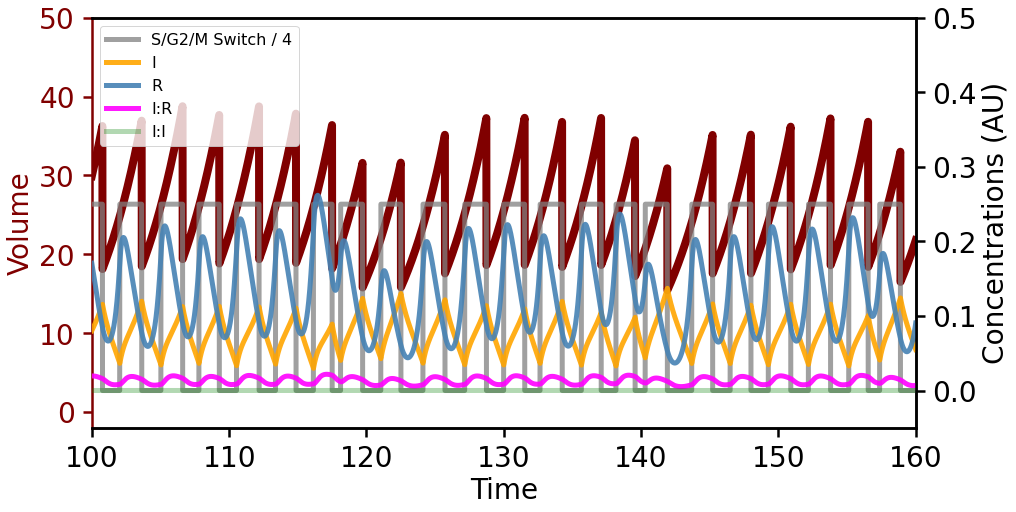

In [87]:
# Create the figure.
f, ax1 = plt.subplots(1,1,figsize=(14,7),constrained_layout=True)

# Set the axis style. 
ax1 = set_axes(ax1)
ax1.tick_params(axis='y',colors=c_volume)
ax1.spines["left"].set_color(c_volume)
ax1.set_ylabel('Volume',size=ax_fontdict['size'],color=c_volume)
ax2 = ax1.twinx()
ax2 = set_axes(ax2)
ax2.spines["left"].set_linewidth(0)
ax2.set_ylabel('Concentrations (AU)',size=ax_fontdict['size'])
ax1.set_xlabel('Time',size=ax_fontdict['size'])

# Plot the relevant variables. 
# Rescale the switch. 
ax2.plot(t,np.divide(y[1,:],4),c=c_switch,lw=small_lw,alpha=0.75,zorder=0,label='S/G2/M Switch / 4')
ax2.plot(t,y[2,:],c=c_output,lw=small_lw,alpha=alpha,zorder=1,label='I')
ax2.plot(t,y[3,:],c=c_s3,lw=small_lw,alpha=alpha,zorder=1,label='R')
ax2.plot(t,y[4,:],c='magenta',lw=small_lw,alpha=alpha,zorder=1,label='I:R')
ax2.plot(t,y[5,:],c='green',lw=small_lw,alpha=0.3,zorder=1,label='I:I')
ax1.plot(t,y[0,:],c=c_volume,lw=big_lw,zorder=2,label='Volume')
ax2.legend(loc='upper left',fontsize=16)

#### Adjust the axis limits to your liking ####
ax1.set_ylim([-2,50])      # Volume Y-axis (left).
ax2.set_ylim([-0.05,0.5])  # Concentrations Y-axis (right).
ax2.set_xlim([100,160])       # Time X-axis. 
plt.show()

## Plot the volume and cycle phase distributions.

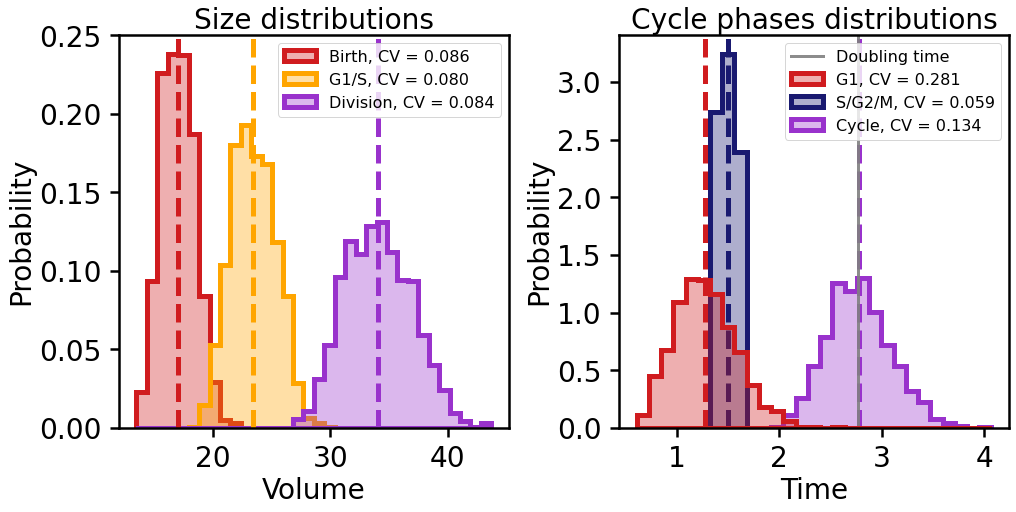

In [88]:
# Bins for the histogram, adjust to your liking if necessary. 
vol_bins = np.linspace(np.amin(analyze_dict['volume_birth'][5:]),np.amax(analyze_dict['volume_div'][5:]),35)
time_bins = np.linspace(min(np.amin(analyze_dict['G1_length'][5:]),np.amin(analyze_dict['S/G2/M_length'][5:])),np.amax(analyze_dict['cycle_length'][5:]),30)
t_doubling = np.log(2)/g_rate

# Create the figure.
f,ax = plt.subplots(1,2,figsize=(14,7),constrained_layout=True)

# Set the axis style. 
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])
ax0.set_title('Size distributions',size=ax_fontdict['size'])
ax0.set_xlabel('Volume',size=ax_fontdict['size'])
ax0.set_ylabel('Probability',size=ax_fontdict['size'])
ax1.set_title('Cycle phases distributions',size=ax_fontdict['size'])
ax1.set_xlabel('Time',size=ax_fontdict['size'])
ax1.set_ylabel('Probability',size=ax_fontdict['size'])

# Plot the relevant variables. 
ax0.hist(analyze_dict['volume_birth'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_birth,facecolor=c_birth_face,lw=small_lw,label='Birth, CV = %.3f'%distribution_dict['cv_volume_birth'])
ax0.hist(analyze_dict['volume_G1/S'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_g1s,facecolor=c_g1s_face,lw=small_lw,label='G1/S, CV = %.3f'%distribution_dict['cv_volume_G1/S'])
ax0.hist(analyze_dict['volume_div'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_cycle,facecolor=c_cycle_face,lw=small_lw,label='Division, CV = %.3f'%distribution_dict['cv_volume_div'])
ax0.axvline(np.mean(analyze_dict['volume_birth'][5:]),ls='--',lw=small_lw,c=c_birth)
ax0.axvline(np.mean(analyze_dict['volume_G1/S'][5:]),ls='--',lw=small_lw,c=c_g1s)
ax0.axvline(np.mean(analyze_dict['volume_div'][5:]),ls='--',lw=small_lw,c=c_mitosis)
ax0.legend(loc='best',fontsize=16)
ax1.hist(analyze_dict['G1_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_birth,facecolor=c_birth_face,lw=small_lw,label='G1, CV = %.3f'%distribution_dict['cv_G1_length'],zorder=3)
ax1.hist(analyze_dict['S/G2/M_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_sg2m,facecolor=c_sg2m_face,lw=small_lw,label='S/G2/M, CV = %.3f'%distribution_dict['cv_S/G2/M_length'],zorder=1)
ax1.hist(analyze_dict['cycle_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_cycle,facecolor=c_cycle_face,lw=small_lw,label='Cycle, CV = %.3f'%distribution_dict['cv_cycle_length'])
ax1.axvline(np.mean(analyze_dict['G1_length'][5:]),ls='--',lw=small_lw,c=c_birth)
ax1.axvline(np.mean(analyze_dict['S/G2/M_length'][5:]),ls='--',lw=small_lw,c=c_sg2m)
ax1.axvline(np.mean(analyze_dict['cycle_length'][5:]),ls='--',lw=small_lw,c=c_mitosis)
ax1.axvline(t_doubling,ls='-',lw=small_lw-2,c='gray',alpha=alpha,label='Doubling time')
ax1.legend(loc='best',fontsize=16)

plt.show()

## Plot the added volumes over different cycle phases.

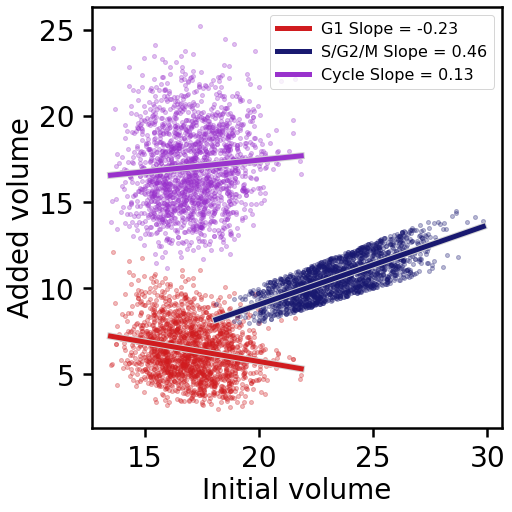

In [89]:
# Event data. 
vol_birth = np.array(analyze_dict['volume_birth'][5:])
vol_g1s = np.array(analyze_dict['volume_G1/S'][5:])
vol_div = np.array(analyze_dict['volume_div'][5:])

# Added volumes 
added_vol_g1 = vol_g1s - vol_birth
added_vol_sg2m = vol_div - vol_g1s
added_vol_cycle = vol_div - vol_birth

# Linear regression
linreg_addvol_g1 = LinearRegression().fit(vol_birth.reshape(-1,1),added_vol_g1.reshape(-1,1))
linreg_addvol_sg2m = LinearRegression().fit(vol_g1s.reshape(-1,1),added_vol_sg2m.reshape(-1,1))
linreg_addvol_cycle = LinearRegression().fit(vol_birth.reshape(-1,1),added_vol_cycle.reshape(-1,1))
x_v_birth = np.linspace(np.amin(vol_birth),np.amax(vol_birth),10)
x_v_g1s = np.linspace(np.amin(vol_g1s),np.amax(vol_g1s),10)
y_g1 = linreg_addvol_g1.predict(x_v_birth.reshape(-1,1))
y_sg2m = linreg_addvol_sg2m.predict(x_v_g1s.reshape(-1,1))
y_cycle = linreg_addvol_cycle.predict(x_v_birth.reshape(-1,1))
slope_g1 = linreg_addvol_g1.coef_[0][0]
slope_sg2m = linreg_addvol_sg2m.coef_[0][0]
slope_cycle = linreg_addvol_cycle.coef_[0][0]

# Create the figure. 
f,ax = plt.subplots(constrained_layout=True,figsize=(7,7))

# Set the axes. 
ax = set_axes(ax)
ax.set_xlabel('Initial volume',fontsize=ax_fontdict['size'])
ax.set_ylabel('Added volume',fontsize=ax_fontdict['size'])

# Plot the relevant variables. 
ax.scatter(vol_birth,added_vol_g1,s=16,c=c_g1,alpha=0.3)
ax.scatter(vol_g1s,added_vol_sg2m,s=16,c=c_sg2m,alpha=0.3)
ax.scatter(vol_birth,added_vol_cycle,s=16,c=c_cycle,alpha=0.3)
ax.plot(x_v_birth,y_g1,c=c_g1,lw=small_lw,zorder=3,label='G1 Slope = %.2f'%slope_g1)
ax.plot(x_v_g1s,y_sg2m,c=c_sg2m,lw=small_lw,zorder=3,label='S/G2/M Slope = %.2f'%slope_sg2m)
ax.plot(x_v_birth,y_cycle,c=c_cycle,lw=small_lw,zorder=3,label='Cycle Slope = %.2f'%slope_cycle)
ax.plot(x_v_birth,y_g1,c='lightgray',lw=small_lw+2,zorder=2)
ax.plot(x_v_g1s,y_sg2m,c='lightgray',lw=small_lw+2,zorder=2)
ax.plot(x_v_birth,y_cycle,c='lightgray',lw=small_lw+2,zorder=2)
ax.legend(loc='best',fontsize=16)

plt.show()

## Plot scaling of network species with volume.

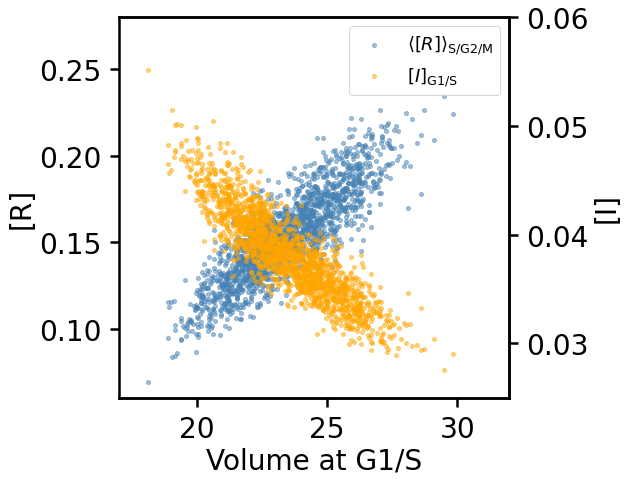

In [92]:
# Event data. 
vol_birth = np.array(analyze_dict['volume_birth'][5:])
vol_g1s = np.array(analyze_dict['volume_G1/S'][5:])
vol_div = np.array(analyze_dict['volume_div'][5:])
I_g1s = np.array(np.array(analyze_dict['S2_G1/S'][5:]))
R_mean_sg2m = np.array(np.array(analyze_dict['S3_mean_S/G2/M'][5:]))

# Create the figure. 
f,ax = plt.subplots(constrained_layout=False,figsize=(7,7))

# Set the axes. 
ax0 = set_axes(ax)
ax1 = ax0.twinx()
ax1 = set_axes(ax1)
ax1.spines["left"].set_linewidth(0)
ax0.set_xlabel('Volume at G1/S',fontsize=ax_fontdict['size']) # X-coordinate, volume at the G1/S transition
ax0.set_ylabel('[R]',fontsize=ax_fontdict['size']) # Y-coordinate (left), concentraton of [R]
ax1.set_ylabel('[I]',fontsize=ax_fontdict['size']) # Y-coordinate (right), concentration of [I]

# Plot the relevant variables. 
s0 = ax0.scatter(vol_g1s,R_mean_sg2m,s=16,c=c_s3,alpha=0.5,zorder=1,label=r'$\langle[R]\rangle_{\mathrm{S/G2/M}}$')
s1 = ax1.scatter(vol_g1s,I_g1s,s=16,c=c_output,alpha=0.5,zorder=2,label=r'$[I]_{\mathrm{G1/S}}$')
ss = [s0,s1]
slab = [s.get_label() for s in ss]
ax0.legend(ss, slab, loc='best',fontsize=18)

#### Adjust the axis limits to your liking ####
ax0.set_ylim([0.06,0.28])    # [R] Y-axis (left).
ax1.set_ylim([0.025,0.06])  # [I] Y-axis (right).
ax1.set_xlim([17,32])      # Volume @ G1/S, X-axis. 
plt.show()

## Compute the control volume response curve.

In [93]:
# Compute the volume response curve. 
control_volume_range, cycle_length = volume_response(V_eq,n_points=21)

Done!


## Plot the control volume response curve. 

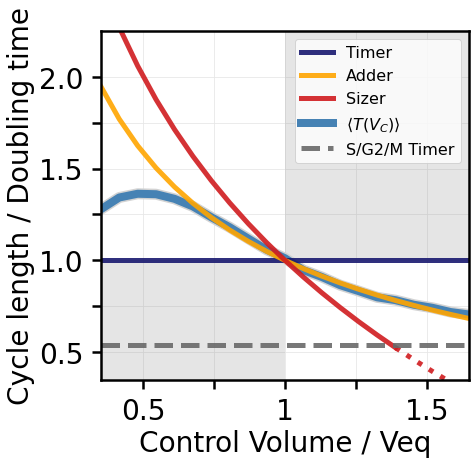

In [94]:
# Normalize the axis by V_eq and the doubling time. 
norm_cycle_length = np.divide(cycle_length,t_doubling)
norm_control_volume_range = np.divide(control_volume_range,V_eq)
norm_sg2m_timer = sg2m_timer_length/t_doubling

# Timer, Adder and Sizer archetype curves for comparison.
norm_T_timer = np.ones_like(norm_control_volume_range)
norm_T_adder = np.divide(np.log(np.divide(1,norm_control_volume_range)+1),g_rate*t_doubling)
norm_T_sizer = np.divide(np.log(np.divide(2,norm_control_volume_range)),g_rate*t_doubling)
i_break_sizer = np.where(norm_T_sizer < norm_sg2m_timer)[0][0] # Index of the control volume where the sizer archetype is no longer allowed because of the incompressible timer length in S/G2/M.

# Create the figure. 
f,ax = plt.subplots(constrained_layout=True,figsize=(6.5,6))

# Set the axes. 
ax = set_axes(ax)
ax.set_xlabel('Control Volume / Veq',fontsize=ax_fontdict['size'])
ax.set_ylabel('Cycle length / Doubling time',fontsize=ax_fontdict['size'])
ax.set_xticks([0.5,0.75,1,1.25,1.5,1.75,2])
ax.set_xticklabels([0.5,'',1,'',1.5,'',2])
ax.set_yticks([0.5,0.75,1,1.25,1.5,1.75,2])
ax.set_yticklabels([0.5,'',1.0,'',1.5,'',2.0])
plt.grid(axis='both', color='0.9',zorder=0)

# Plot the relevant variables. 
ax.plot(norm_control_volume_range,norm_T_timer,ls='-',c=c_sg2m,lw=small_lw,alpha=0.9,zorder=4,label='Timer')
ax.plot(norm_control_volume_range,norm_T_adder,lw=small_lw,ls='-',c=c_g1s,alpha=0.9,zorder=4,label='Adder')
ax.plot(norm_control_volume_range[:i_break_sizer+1],norm_T_sizer[:i_break_sizer+1],lw=small_lw,ls='-',c=c_g1,alpha=0.9,zorder=4,label='Sizer')
ax.plot(norm_control_volume_range[i_break_sizer:],norm_T_sizer[i_break_sizer:],lw=small_lw,ls=':',c=c_g1,alpha=0.9,zorder=4)
ax.fill_between([0.35,1],y1=[1,1],facecolor='grey',alpha=0.2,zorder=2)
ax.fill_between([1,1.65],y1=[10,10],y2=[1,1],facecolor='grey',alpha=0.2,zorder=2)
ax.plot(norm_control_volume_range,norm_cycle_length,lw=big_lw,c=c_s3,alpha=1,zorder=3,ls='-',label=r'$\langle T(V_C) \rangle$')
ax.plot(norm_control_volume_range,norm_cycle_length,lw=big_lw+3,c='lightgrey',alpha=1,zorder=2,ls='-')
ax.plot(norm_control_volume_range,norm_sg2m_timer*np.ones_like(norm_control_volume_range),ls='--',c='dimgrey',lw=small_lw,alpha=0.9,zorder=5,label='S/G2/M Timer')
ax.legend(loc='best',fontsize=16)

#### Adjust the axis limits to your liking ####
ax.set_ylim([0.35,2.25])
ax.set_xlim([0.35,1.65])

plt.show()

## Control added volume.

We use the same added volume data from the earlier 'regular' simulation, but overlay the added volume response curve.

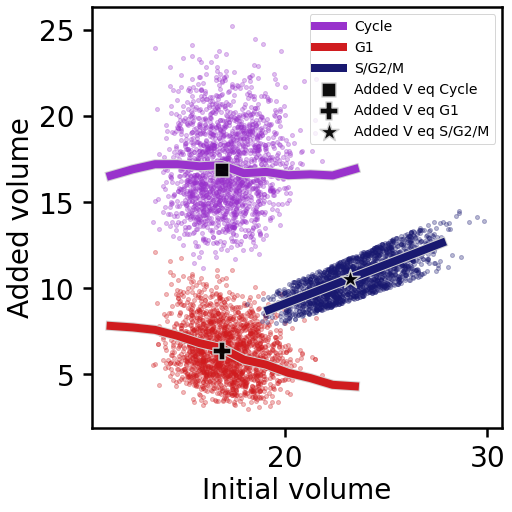

In [95]:
# Define the relevant variables. 
if pombe:
    # S. pombe cycle structure, control volume is at division.
    control_volume_birth = np.divide(control_volume_range,2) 
    control_volume_g1s = control_volume_birth*np.exp(g_rate*sg2m_timer_length)
    control_V_eq_birth = V_eq/2
    control_V_eq_g1s = control_V_eq_birth*np.exp(g_rate*sg2m_timer_length)
else:
    # S. cerevisiae cycle structure, control volume is at G1/S
    control_volume_birth = np.array(control_volume_range)*np.exp(g_rate*sg2m_timer_length)/2
    control_volume_g1s = control_volume_birth*np.exp(g_rate*(np.array(cycle_length)-sg2m_timer_length))
    control_V_eq_birth = V_eq*np.exp(g_rate*sg2m_timer_length)/2
    control_V_eq_g1s = V_eq
control_volume_div = control_volume_birth*np.exp(g_rate*np.array(cycle_length))
control_V_eq_div = control_V_eq_birth*np.exp(g_rate*t_doubling)
added_control_volume_g1 = np.subtract(control_volume_g1s,control_volume_birth)
added_control_volume_sg2m = np.subtract(control_volume_div,control_volume_g1s)
added_control_volume_cycle = np.subtract(control_volume_div,control_volume_birth)
added_V_eq_g1 = control_V_eq_g1s - control_V_eq_birth
added_V_eq_sg2m = control_V_eq_div - control_V_eq_g1s
added_V_eq_cycle = control_V_eq_div - control_V_eq_birth    
    
# Create the figure. 
f,ax = plt.subplots(constrained_layout=True,figsize=(7,7))

# Set the axes. 
ax = set_axes(ax)
ax.set_xlabel('Initial volume',fontsize=ax_fontdict['size'])
ax.set_ylabel('Added volume',fontsize=ax_fontdict['size'])

# Plot the relevant variables. 
ax.scatter(vol_birth,added_vol_g1,s=16,c=c_g1,alpha=0.3)
ax.scatter(vol_g1s,added_vol_sg2m,s=16,c=c_sg2m,alpha=0.3)
ax.scatter(vol_birth,added_vol_cycle,s=16,c=c_cycle,alpha=0.3)
ax.plot(control_volume_birth[5:-4],added_control_volume_cycle[5:-4],c=c_cycle,lw=big_lw,ls='-',zorder=3,label='Cycle')
ax.plot(control_volume_birth[5:-4],added_control_volume_g1[5:-4],c=c_g1,lw=big_lw,ls='-',zorder=3,label='G1')
ax.plot(control_volume_g1s[5:-4],added_control_volume_sg2m[5:-4],c=c_sg2m,lw=big_lw,ls='-',zorder=3,label='S/G2/M')
ax.plot(control_volume_birth[5:-4],added_control_volume_cycle[5:-4],c='lightgray',lw=big_lw+2,ls='-',zorder=2)
ax.plot(control_volume_birth[5:-4],added_control_volume_g1[5:-4],c='lightgray',lw=big_lw+2,ls='-',zorder=2)
ax.plot(control_volume_g1s[5:-4],added_control_volume_sg2m[5:-4],c='lightgray',lw=big_lw+2,ls='-',zorder=2)
ax.scatter(control_V_eq_birth,added_V_eq_cycle,s=200,c='k',marker='s',zorder=5,alpha=0.95,ec='lightgrey',lw=1.5,label='Added V eq Cycle')
ax.scatter(control_V_eq_birth,added_V_eq_g1,s=300,c='k',marker='P',zorder=5,alpha=0.95,ec='lightgrey',lw=1.5,label='Added V eq G1')
ax.scatter(control_V_eq_g1s,added_V_eq_sg2m,s=400,c='k',marker='*',zorder=5,alpha=0.95,ec='lightgrey',lw=1.5,label='Added V eq S/G2/M')
ax.legend(loc='best',fontsize=14)

plt.show()

# Example 2 - Model B
Here, we will only look at the **dynamics**, **size and time distributions** and **control volume time distributions** for Model B.

___ 

## Model and parameter selection.    
Define values in the `hyperparameters` dictionary for model selection.

In [96]:
# Dictionary of hyperparameters for model and various parameter selection
hyperparameters = {'model':'B',      # Model name (string). Can be 'A1','A2','B' from the main text. 
                  'g_rate':0.25,      # Growth rate (float). Default is '0.25'.
                  't_g1s':0.8,        # Threshold for sigmoid-shaped G1/S transition (float). Default value is 0.8.
                  'n_g1s':8,          # Coefficient for sigmoid-shaped G1/S transition (float). Default value is 8.
                  'sg2m_timer_length':1.5, # Length of the S/G2/M timer (float). Default value is 1.5.
                  'pombe':0,          # S. pombe cycle structure of timer --> sizer (bool). Default value is 0 for S. cerevisiae structure sizer --> timer. 
                  'dt':0.01,          # Time step for the Euler integrator. Default is '0.01'.
                  }

# Update the variables such that they correspond to the correct values stored in the dictionaries. 
globals().update(hyperparameters)
globals()['V_eq'] = V_eq_dict['model_'+model]
t_doubling = np.log(2)/g_rate
parameter_names = list(parameters['param_model_'+model])
globals().update(parameters['param_model_'+model])
all_parameter_names = ['p_2','t_12','n_12','t_22','n_22','t_32','n_32','t_42','n_42','t_52','n_52','b_2',
                      'p_3','t_13','n_13','t_23','n_23','t_33','n_33','t_43','n_43','t_53','n_53','b_3',
                      'b_4','kf1','kf2','kf3','kb1','kb2','kb3','d_2','d_3','d_4','d_5','d_6','d_7','kf','kb']
for item in all_parameter_names:
    if item not in parameter_names:
        # Update parameter values such that any parameter NOT in the parameters dict is set to 0. 
        globals().update({item:0})

## Compute the dynamics.

In [97]:
t, y = integrate_euler(end_time = 4000) # Run the simulation. 
analyze_dict = analyze_run(t,y) # Analyze the simulation to extract values at different events in the lineage.
distribution_dict = analyze_dist(analyze_dict) # Analyze the distributions in 'analyze_dict' and extract their means, std and cv.
clear_output()

## Plot the dynamics.

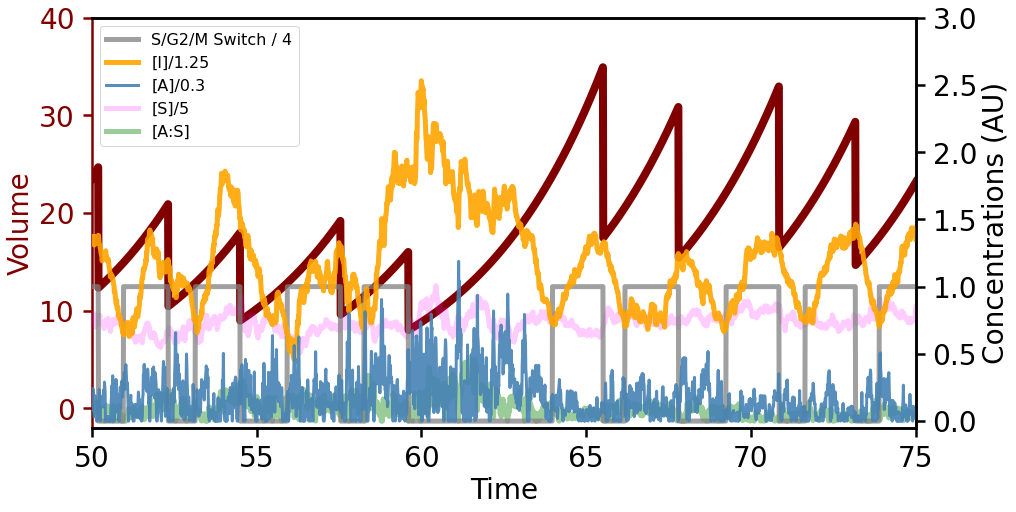

In [101]:
# Create the figure.
f, ax1 = plt.subplots(1,1,figsize=(14,7),constrained_layout=True)

# Set the axis style. 
ax1 = set_axes(ax1)
ax1.tick_params(axis='y',colors=c_volume)
ax1.spines["left"].set_color(c_volume)
ax1.set_ylabel('Volume',size=ax_fontdict['size'],color=c_volume)
ax2 = ax1.twinx()
ax2 = set_axes(ax2)
ax2.spines["left"].set_linewidth(0)
ax2.set_ylabel('Concentrations (AU)',size=ax_fontdict['size'])
ax1.set_xlabel('Time',size=ax_fontdict['size'])

# Plot the relevant variables. 
# Rescale [I], [A] and [S]. 
ax2.plot(t,y[1,:],c=c_switch,lw=small_lw,alpha=0.75,zorder=2,label='S/G2/M Switch / 4')
ax2.plot(t,np.divide(y[2,:],1.25),c=c_output,lw=small_lw,alpha=alpha,zorder=2,label='[I]/1.25')
ax2.plot(t,np.divide(y[3,:],0.3),c=c_s3,lw=small_lw-2,alpha=alpha,zorder=2,label='[A]/0.3')
ax2.plot(t,np.divide(y[4,:],5),c='magenta',lw=small_lw,alpha=0.2,zorder=1,label='[S]/5')
ax2.plot(t,y[5,:],c='green',lw=small_lw,alpha=0.4,zorder=1,label='[A:S]')
ax1.plot(t,y[0,:],c=c_volume,lw=big_lw,zorder=2,label='Volume')
ax2.legend(loc='upper left',fontsize=16)

#### Adjust the axis limits to your liking ####
ax1.set_ylim([-2,40])      # Volume Y-axis (left).
ax2.set_ylim([-0.05,3])  # Concentrations Y-axis (right).
ax2.set_xlim([50,75])       # Time X-axis. 
plt.show()

## Plot the volume and cycle phase distributions. 

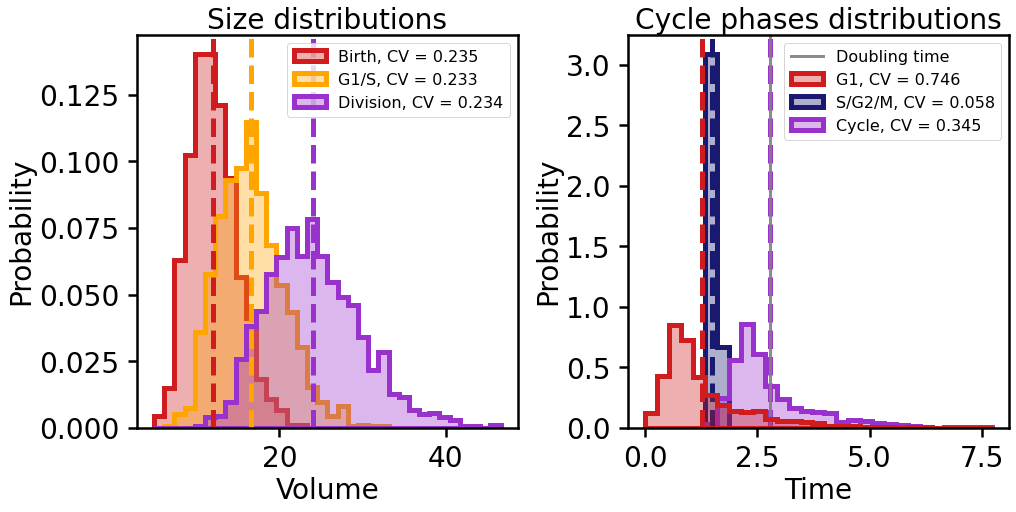

In [102]:
# Bins for the histogram, adjust to your liking if necessary. 
vol_bins = np.linspace(np.amin(analyze_dict['volume_birth'][5:]),np.amax(analyze_dict['volume_div'][5:]),35)
time_bins = np.linspace(np.amin(analyze_dict['G1_length'][5:]),np.amax(analyze_dict['cycle_length'][5:]),30)
t_doubling = np.log(2)/g_rate

# Create the figure.
f,ax = plt.subplots(1,2,figsize=(14,7),constrained_layout=True)

# Set the axis style. 
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])
ax0.set_title('Size distributions',size=ax_fontdict['size'])
ax0.set_xlabel('Volume',size=ax_fontdict['size'])
ax0.set_ylabel('Probability',size=ax_fontdict['size'])
ax1.set_title('Cycle phases distributions',size=ax_fontdict['size'])
ax1.set_xlabel('Time',size=ax_fontdict['size'])
ax1.set_ylabel('Probability',size=ax_fontdict['size'])

# Plot the relevant variables. 
ax0.hist(analyze_dict['volume_birth'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_birth,facecolor=c_birth_face,lw=small_lw,label='Birth, CV = %.3f'%distribution_dict['cv_volume_birth'])
ax0.hist(analyze_dict['volume_G1/S'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_g1s,facecolor=c_g1s_face,lw=small_lw,label='G1/S, CV = %.3f'%distribution_dict['cv_volume_G1/S'])
ax0.hist(analyze_dict['volume_div'][5:],bins=vol_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_cycle,facecolor=c_cycle_face,lw=small_lw,label='Division, CV = %.3f'%distribution_dict['cv_volume_div'])
ax0.axvline(np.mean(analyze_dict['volume_birth'][5:]),ls='--',lw=small_lw,c=c_birth)
ax0.axvline(np.mean(analyze_dict['volume_G1/S'][5:]),ls='--',lw=small_lw,c=c_g1s)
ax0.axvline(np.mean(analyze_dict['volume_div'][5:]),ls='--',lw=small_lw,c=c_mitosis)
ax0.legend(loc='best',fontsize=16)
ax1.hist(analyze_dict['G1_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_birth,facecolor=c_birth_face,lw=small_lw,label='G1, CV = %.3f'%distribution_dict['cv_G1_length'],zorder=3)
ax1.hist(analyze_dict['S/G2/M_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_sg2m,facecolor=c_sg2m_face,lw=small_lw,label='S/G2/M, CV = %.3f'%distribution_dict['cv_S/G2/M_length'],zorder=1)
ax1.hist(analyze_dict['cycle_length'][5:],bins=time_bins,density=True,stacked=True,histtype='stepfilled',ls='solid',ec=c_cycle,facecolor=c_cycle_face,lw=small_lw,label='Cycle, CV = %.3f'%distribution_dict['cv_cycle_length'])
ax1.axvline(np.mean(analyze_dict['G1_length'][5:]),ls='--',lw=small_lw,c=c_birth)
ax1.axvline(np.mean(analyze_dict['S/G2/M_length'][5:]),ls='--',lw=small_lw,c=c_sg2m)
ax1.axvline(np.mean(analyze_dict['cycle_length'][5:]),ls='--',lw=small_lw,c=c_mitosis)
ax1.axvline(t_doubling,ls='-',lw=small_lw-2,c='gray',alpha=alpha,label='Doubling time')
ax1.legend(loc='best',fontsize=16)

plt.show()

## Compute the control volume cycle length distributions. 

In [103]:
# Compute the control volume time distributions. 
control_volume_range, cycle_length_data = volume_response_fluct(6,16,6)

Done!


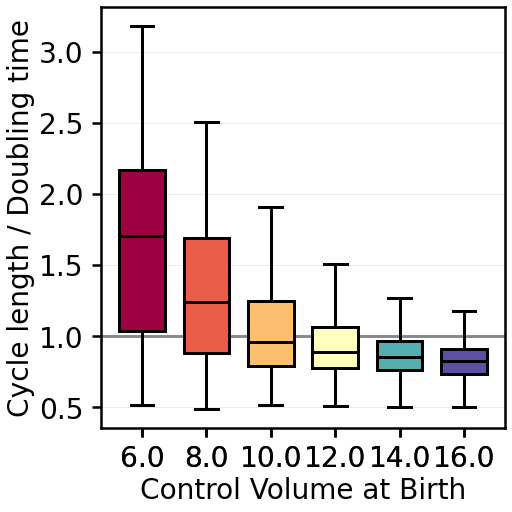

In [106]:
# Define the relevant variables. 
cmap_d = plt.get_cmap('Spectral')
vmin,vmax = 6,15
norm_volume_d = mpl.colors.DivergingNorm(vmin=vmin,vcenter=12,vmax=vmax)
clear_output()
c_d = cmap_d(norm_volume_d(control_volume_range))
#print(cycle_length)
norm_cycle_length_data = np.divide(cycle_length_data,t_doubling)
#print(norm_cycle_length_data)

# Create the figure. 
f, ax = plt.subplots(1,1,figsize=(7,7),constrained_layout=True)

# Set the axes. 
ax=set_axes(ax)
ax.set_xlabel('Control Volume at Birth',fontsize=ax_fontdict['size'])
ax.set_ylabel('Cycle length / Doubling time',fontsize=ax_fontdict['size'])

# Plot the relevant variables. 
for i in range(len(control_volume_range)):
    r,g,b,a = mpl.colors.to_rgba(c_d[i])
    a = 1
    c_i_face = r,g,b,a
    # Just the face, not the outlines
    p = ax.boxplot(norm_cycle_length_data[i],notch=0,whis=1.5,widths=1.4,vert=1,positions=[control_volume_range[i]],zorder=5,
                   showfliers=False,showmeans=False,
                  patch_artist=True,boxprops=dict(facecolor=c_i_face,color='None',zorder=5,lw=0),
                  medianprops = dict(color='k',lw=0),
                  whiskerprops = dict(color='k',lw=0),
                  capprops = dict(color='k',lw=0))
    #Just the outlines, not the face
    p = ax.boxplot(norm_cycle_length_data[i],notch=0,whis=1.5,widths=1.42,vert=1,positions=[control_volume_range[i]],zorder=3,
                   showfliers=False,showmeans=False,
                  patch_artist=True,boxprops=dict(facecolor='None',color='k',zorder=6,lw=3,alpha=1),
                  medianprops = dict(color='k',lw=3,zorder=6),
                  whiskerprops = dict(color='k',lw=3),
                  capprops = dict(color='k',lw=3))
ax.axhline(1,lw=3,ls='-',c='grey',alpha=0.9,zorder=2)
plt.grid(axis='y',which='both',color='0.9',zorder=0)

plt.show()